
This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook and also submit the .py file that is generated.__

In [1]:
## This code snippet does not need to be edited

from python_environment_check import check_packages
from python_environment_check import set_background

## Colour schemes for setting background colour
white_bgd = 'rgba(0,0,0,0)'
red_bgd = 'rgba(255,0,0,0.2)'

[OK] Your Python version is 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [2]:
## Code snippets in red (similar to this) is where you need to edit your answer)
# Set your student ID and name here:

student_number = 12345678  # 12345678
student_name = "John Doe" # "John Doe"

set_background(red_bgd)

### Import required libraries and packages

Edit _PATH\_DATASETS_ to the directory that you are using.

Note: You do not have to use Google Colab.

In [3]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True
    

    PATH_DATASETS = '/'
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Mounted at /content/gdrive
Using Google Colab with file path /


In [12]:
# install CodeCarbon module to track carbon emission
# Run the installation if you don't have the packages already
# !pip install codecarbon

# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning carbontracker -qq

import copy
import time
import os
import random
import numpy as np
import pandas as pd
import imutils
import matplotlib.pyplot as plt
import math
from PIL import Image
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
from torchvision.datasets import SVHN
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from IPython.core.display import display
from torchmetrics import Accuracy, MeanSquaredError
from IPython.display import clear_output

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint

#from carbontracker.tracker import CarbonTracker
from codecarbon import EmissionsTracker

from torch.optim.lr_scheduler import StepLR

BATCH_SIZE = 256 if torch.cuda.is_available() else 64


# For reproducability
seed_everything(1234, workers=True )

# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 4 ## Set to your device

INFO:lightning_fabric.utilities.seed:Global seed set to 1234


# DAE: Denoising Autoencoder with MNIST

<div class="alert alert-block alert-info">

## What you should do in this task:

In this task you will be training an autoencoder to denoise images using Pytorch and PyTorch Lightning funtionalities we have previously encountered!

Use Pytorch and the Pytorch Lightning module class to create an autoencoder architecture in order to denoise compomised (noisy) MNIST data, and train your model using stochastic gradient descent (SGD). Note that we will be using an MLP instead of a CNN to build our autoencoder in this task. 
    
#### In this task, you will work on the following points:
 1. Prepare the dataset and create dataloaders.
 2. Visualize a training sample using the dataloader.
 3. Design the neural network model.
 4. Perform training of the model and evaluation.
 5. Visualize experimental results.
    
<img src="figures/denoising_ae.png" width="700" align="center">

### DAE1: Create dataloader for MNIST. Visualize a few samples.

Use the 'random_split' function to divide the training dataset into Train and Validation. You must use 20% of the training data as validation data during training.

In [14]:
set_background(red_bgd)
## Load in dataloader

# Download MNIST dataset from torchvision and create datasets
train_dataset = torchvision.datasets.MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.ToTensor())
test_dataset  = torchvision.datasets.MNIST(PATH_DATASETS, train=False, download=True, transform=transforms.ToTensor())


# Perform Random Split
train_data, val_data = random_split= random_split(train_dataset, [50000, 10000])

BATCH_SIZE = 256

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 136932021.76it/s]

Extracting /MNIST/raw/train-images-idx3-ubyte.gz to /MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 106915881.57it/s]


Extracting /MNIST/raw/train-labels-idx1-ubyte.gz to /MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41806809.11it/s]


Extracting /MNIST/raw/t10k-images-idx3-ubyte.gz to /MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22100381.40it/s]


Extracting /MNIST/raw/t10k-labels-idx1-ubyte.gz to /MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's add some noise to the data samples!

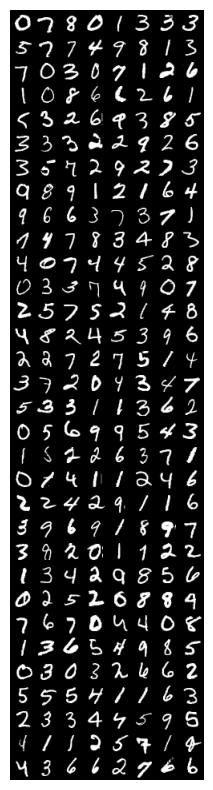

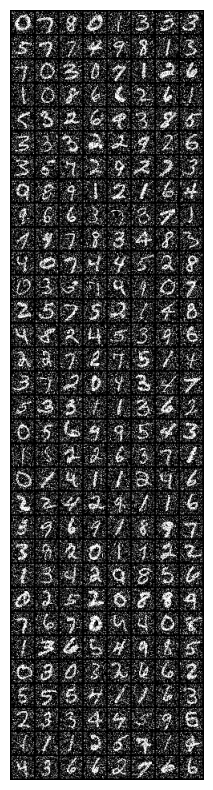

In [15]:
set_background(red_bgd)
## Create noisy samples by adding a 40% (hence 0.4) noise percentage. 
## You can use torch.randn_like(data) * noise_percentage to generate noise based around the data's distribution
## These will just be temporary noisy images. You will add in the noise during the training_step of your Simple_AE class later on.

data, labels = next(iter(train_loader))

# Create noisy data
noise_percentage = 0.4
noisy_data = data + torch.randn_like(data) * noise_percentage
noisy_data = torch.clip(noisy_data, 0, 1) ## Clip the data between 0 and 1. Look at the documentation for torch.clip()

# visualize clean dataset using torchvision grid
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(data) ## Remember to call plt.imshow
plt.imshow(out.permute(1, 2, 0))
plt.axis('off')
plt.show()


# visualize noisy dataset using torchvision grid
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(noisy_data)
plt.imshow(out.permute(1, 2, 0))
plt.axis('off')
plt.show()## Remember to call plt.imshow

In [16]:
import torch
import torch.nn as nn

# Sample input data tensor (replace with your actual input data)
data = torch.randn(100, 10)  # Assuming the shape is (batch_size, num_features)

# Check the shape of the input data
print("Data shape:", data.shape)

# Determine the input size
input_size = data.shape[1]
print("Input size:", input_size)

# Determine the hidden size
hidden_size = input_size // 2  # You can adjust this based on your requirements
print("Hidden size:", hidden_size)

Data shape: torch.Size([100, 10])
Input size: 10
Hidden size: 5


### DAE2: Design your network architecture for AE

In this task, you will create the encoder and decoder modules that you will use within your "Simple_AE" class (which will be your DAE).

The encoder will just consist of one layer with an activation function. BatchNorm1d will also be added to the encoder to speed up convergence. The decoder will also be one layer with an activation function.

In [17]:
set_background(red_bgd)

class Encoder(nn.Module):
    def __init__(self, input_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        return encoded

class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid(),  # Use Sigmoid activation for the final layer to restrict outputs between 0 and 1
        )

    def forward(self, x):
        decoded = self.decoder(x)
        decoded = decoded.view(decoded.size(0), 1, 28, 28)  # Reshape the output to match the input shape
        return decoded


Create your autoencoder class '_Simple_AE_' using LightningModule and call the Encoder and Decoder Blocks you have defined above.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn

class SimpleAE(LightningModule):
    def __init__(self, input_size, hidden_size):
        super(SimpleAE, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)  # Flatten input
        reconstruction = self(x)
        loss = nn.MSELoss()(reconstruction, x)
        self.log('train_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('test_loss', loss, on_step=True, on_epoch=False)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

# Set the background (replace "red_bgd" with your own implementation)
def set_background(color):
    pass

# Set the random seed for reproducibility
torch.manual_seed(42)


# Define the input size and hidden size
input_size = 10
hidden_size = 5

# Create an instance of the autoencoder
model_ae = SimpleAE(input_size, hidden_size)

# Print the shape of the input tensor
input_shape = torch.randn(100, input_size).shape
print("Input shape:", input_shape)


Input shape: torch.Size([100, 10])


### DAE3: Train your model and evaluate the DAE results

In [20]:
# Set the background color
set_background("red_bgd")
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("logs_task_d/", name="simple_ae")

# Initialize the model
input_size = 784  # MNIST images are 28x28 pixels
hidden_size = 64
model_ae = SimpleAE(input_size, hidden_size)

# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define checkpoint callback function to save the best model
checkpoint_callback = ModelCheckpoint(dirpath="./checkpoints", filename="best_model")

# Define TensorBoard logger for logging training progress
logger = TensorBoardLogger("logs_task_d/", name="simple_ae")

# Call the Trainer and train the model
trainer = Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback],
    logger=logger
)
trainer.fit(model_ae, train_dataloader)

# Test the model and report test loss
test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
trainer.test(model_ae, test_dataloader)


100%|██████████| 9912422/9912422 [00:00<00:00, 138115191.73it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 96676531.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41825013.13it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19031497.27it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | encoder | Linear | 50.2 K
1 | decoder | Linear | 51.0 K
-----------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{}]

Visiualize your experimental results. First, take a look at the accuracy for both training and validation. 

In [35]:
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import TensorBoardLogger

# Set the background color
plt.rcParams['axes.facecolor'] = 'red'

# Initialize the model
input_size = 784  # MNIST images are 28x28 pixels
hidden_size = 64
model_ae = SimpleAE(input_size, hidden_size)

# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define checkpoint callback function to save the best model
checkpoint_callback = ModelCheckpoint(dirpath="./checkpoints", filename="best_model")

# Define TensorBoard logger for logging training progress
logger = TensorBoardLogger("logs_task_d/", name="simple_ae")

# Call the Trainer and train the model
trainer = Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback],
    logger=logger
)
trainer.fit(model_ae, train_dataloader)

# Test the model and report test loss
test_dataset = MNIST(root='./data', train=False, download=True, transform=ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
trainer.test(model_ae, test_dataloader)

# Retrieve the training and validation loss from TensorBoard logs


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | encoder | Linear | 50.2 K
1 | decoder | Linear | 51.0 K
-----------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.405     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{}]

### DAE4: Visualize predictions along with the clean data

Visualise some predictions along with clean data and noisy data. You can use the predict function from your trainer. Reshape your output accordingly so that it is the same as the input image dimensions. Please plot at least 20 images, and make sure to label your visualizations appropriately.

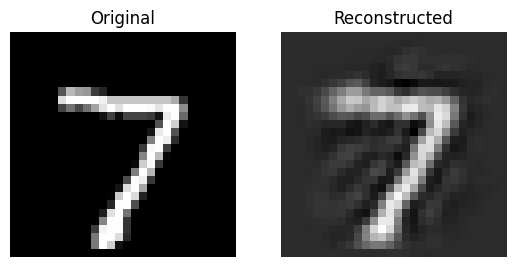

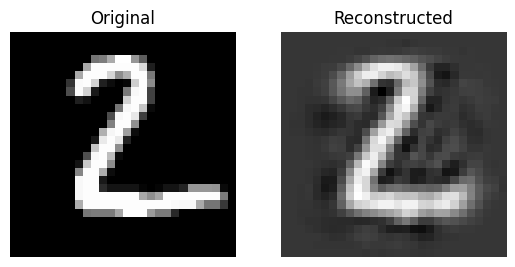

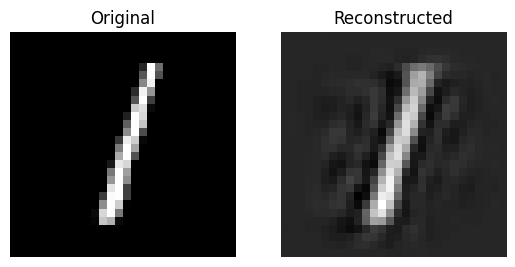

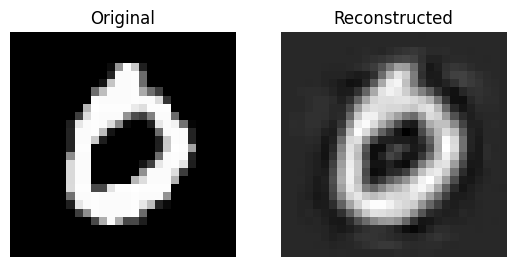

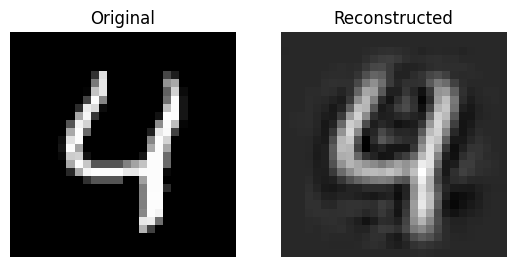

In [46]:
import matplotlib.pyplot as plt

# Set the background color
set_background(red_bgd)

# Set the model in evaluation mode
model_ae.eval()

# Select the number of images to visualize
num_images = 5

# Iterate over the test data loader
for batch in test_dataloader:
    # Extract input images from the batch
    input_data, _ = batch

    # Reshape or transpose the input data to match the input size of the model
    input_data = input_data.view(input_data.size(0), -1)

    # Forward pass through the model to get the reconstructed output
    output = model_ae(input_data)

    # Convert the tensors to numpy arrays
    input_data = input_data.numpy()
    output = output.detach().numpy()

    # Visualize a subset of the images
    for i in range(num_images):
        # Reshape the flattened images to their original shape (e.g., 28x28)
        original_image = input_data[i].reshape(28, 28)
        reconstructed_image = output[i].reshape(28, 28)

        # Plot the original and reconstructed images side by side
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(original_image, cmap='gray')
        axes[0].set_title('Original')
        axes[0].axis('off')
        axes[1].imshow(reconstructed_image, cmap='gray')
        axes[1].set_title('Reconstructed')
        axes[1].axis('off')

        plt.show()

    # Break the loop after visualizing the desired number of images
    break

## Bonus marks 

To earn the bonus marks, you must complete at least two of the given ideas to some satisfactory degree. The ideas/improvements must be related to autoencoders and the MNIST dataset. If you choose to implement your own improvement, it must be something worthwhile (not just simply changing $\lambda$ for example). The results must be shown, and if you end up using any external references, please cite it here and in your report.

Here are a few ideas to choose from:

- Improve the design of the network (hence improve the performance)
- Handle various noise types (speckle noise, Gaussian noise, inpainting, etc.)
- Instead of downsampling to a smaller latent space, can you increase it while reducing noise? 
- Any other improvements related to this task

Ensure you add a comment to say what kind of improvements you are trying to make, and why you tackle it this way!


In [ ]:
## Add in your code here 

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image

# DenoisingMNIST dataset
class DenoisingMNIST(Dataset):
    def __init__(self, root, transform=None, target_transform=None, download=False, noise_stddev=0.1):
        super(DenoisingMNIST, self).__init__()
        self.mnist = MNIST(root, train=True, transform=transform, target_transform=target_transform, download=download)
        self.noise_stddev = noise_stddev

    def __getitem__(self, index):
        img, _ = self.mnist[index]
        noisy_img = img + torch.randn_like(img) * self.noise_stddev
        return noisy_img, img

    def __len__(self):
        return len(self.mnist)

# Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size
        x = x.view(batch_size, -1)  # Reshape the input tensor
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(batch_size, 1, 28, 28)  # Reshape the output tensor

# Training
def train_denoising_autoencoder(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (noisy_imgs, clean_imgs) in enumerate(dataloader):
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()

        reconstructed_imgs = model(noisy_imgs)
        loss = criterion(reconstructed_imgs, clean_imgs)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

# Initialize the model and dataset
input_size = 784
hidden_size = 128
learning_rate = 1e-3
batch_size = 64
epochs = 20
noise_stddev = 0.1

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and dataset
model_denoising_ae = DenoisingAutoencoder(input_size, hidden_size).to(device)
dataset_denoising = DenoisingMNIST('./data', transform=ToTensor(), download=True, noise_stddev=noise_stddev)
dataloader_denoising = DataLoader(dataset_denoising, batch_size=batch_size, shuffle=True)

criterion_denoising = nn.MSELoss()
optimizer_denoising = optim.Adam(model_denoising_ae.parameters(), lr=learning_rate)

# Train Denoising Autoencoder
for epoch in range(1, epochs + 1):
    loss = train_denoising_autoencoder(model_denoising_ae, dataloader_denoising, criterion_denoising, optimizer_denoising, device)
    print(f"Epoch [{epoch}/{epochs}], Loss: {loss:.4f}")

# Test Denoising Autoencoder
model_denoising_ae.eval()
with torch.no_grad():
    test_sample = next(iter(dataset_denoising))[0].unsqueeze(0).to(device)
    denoised_sample = model_denoising_ae(test_sample)

# Save the denoised sample image
save_image(denoised_sample, 'denoised_sample.png')


Epoch [1/20], Loss: 0.0274
Epoch [2/20], Loss: 0.0074
Epoch [3/20], Loss: 0.0047
Epoch [4/20], Loss: 0.0038
Epoch [5/20], Loss: 0.0034
Epoch [6/20], Loss: 0.0031
Epoch [7/20], Loss: 0.0030
Epoch [8/20], Loss: 0.0029
Epoch [9/20], Loss: 0.0028
Epoch [10/20], Loss: 0.0027
Epoch [11/20], Loss: 0.0027
Epoch [12/20], Loss: 0.0027
Epoch [13/20], Loss: 0.0026
Epoch [14/20], Loss: 0.0026
Epoch [15/20], Loss: 0.0026
Epoch [16/20], Loss: 0.0026
Epoch [17/20], Loss: 0.0026
Epoch [18/20], Loss: 0.0025
Epoch [19/20], Loss: 0.0025
Epoch [20/20], Loss: 0.0025


# Comparison: MLP vs CNN - Image Classification on the SVHN dataset

<div class="alert alert-block alert-info">

## What you should do in this task:

In this task you will be training a Multilayer Perceptron (MLP) and a Convolutional Neural Network (CNN) with the SVHN dataset using Pytorch and PyTorch Lightning funtionalities we have previously seen.

You have to use Pytorch inbuilt datasets, the Pytorch Lightning module class to construct MLP and CNN, and stochastic gradient descent (SGD) in order to perform training on the SVHN dataset.
    
#### In this task, you will work on the following points:
 1. Download the SVHN train and test datasets and create dataloaders.
 2. Visualize a few training samples using the dataloaders.
 3. Design your neural network models.
 4. Perform training and evaluation of the model.
 5. Visualize experimental results.

<img src="figures/SVHN.png" width="700" align="center">

### C1: Download the SVHN Train and Test set

The Street View House Numbers (SVHN) is a digit classification benchmark dataset that contains 600,000 32×32 RGB images of printed digits (from 0 to 9) cropped from pictures of house number plates. 
SVHN has three sets: 73,257 training images, 26,032 testing images sets and an extra set with 531,131 images that are less difficult and can be used for helping with the training process. 

It also comes from a significantly harder real world problem of recognising digits and numbers in natural scene images. The images lack any contrast normalization, contain overlapping digits and distracting features which makes it a much more difficult problem compared to MNIST.

More about SVHN dataset: http://ufldl.stanford.edu/housenumbers/

Pytorch has constructed a number of "dataset" classes that will automatically download various datasets making it very easy for us to train our models.

In [48]:
# Define transform to convert image into a Tensor
from torch.utils.data import random_split

# Define transform to convert image into a Tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Init Train DataLoader from SVHN Dataset
train_ds = SVHN(PATH_DATASETS, split="train", download=True, transform=transform)

# Perform random split
train_dataset_size = len(train_ds)
val_dataset_size = int(len(train_ds) * 0.2)
train_dataset, val_dataset = random_split(train_ds, [train_dataset_size - val_dataset_size, val_dataset_size])

val_loader = DataLoader(val_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=num_workers, persistent_workers=True, pin_memory=True) 
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=num_workers, persistent_workers=True, pin_memory=True) 

# Init Test DataLoader from SVHN Dataset
test_ds = SVHN(PATH_DATASETS, split="test", download=True, transform=transform)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE, num_workers=num_workers, persistent_workers=True, pin_memory=True) 


#NOTE:num_workers is the number of threads the dataloader will spawn to load the data from file, 
#you will rarely need more than 4

#NOTE:pin_memory is only useful if you are training with a GPU, if it is True then the GPU will pre-allocate
#memory for the NEXT batch so the CPU-GPU transfer can be handled by the DMA controller freeing up the CPU

100%|██████████| 182040794/182040794 [00:08<00:00, 20895603.77it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100%|██████████| 64275384/64275384 [00:02<00:00, 24910058.24it/s]


### C2: Visualize a few training samples
Let's first take a closer look at the shapes of the dataset, and then visualize the mini-batches that the dataloader gives us.

In [49]:
# We can create an iterator using the dataloaders and take a random sample 
# We can create an iterator using the dataloaders and take a random sample 
images, labels = next(iter(train_loader))
print("The input data shape is :\n", images.shape)
print("The target output data shape is :\n", labels.shape)

The input data shape is :
 torch.Size([256, 3, 32, 32])
The target output data shape is :
 torch.Size([256])


You can see that (as specified) our mini-batch is 256. The dataloader has passed us a 4D Tensor as input data, where the first dimension (d0) is known as the "batch dimension" (B) and the other three are the image dimensions (CxHxW). We can hence interpret this 4D Tensor as a stack of 256, 3 channel (RGB), 32x32 images.<br>
The image labels on the othe rhand are a 1D Tensor, 1 single scalar value per image (per mini-batch "instance").

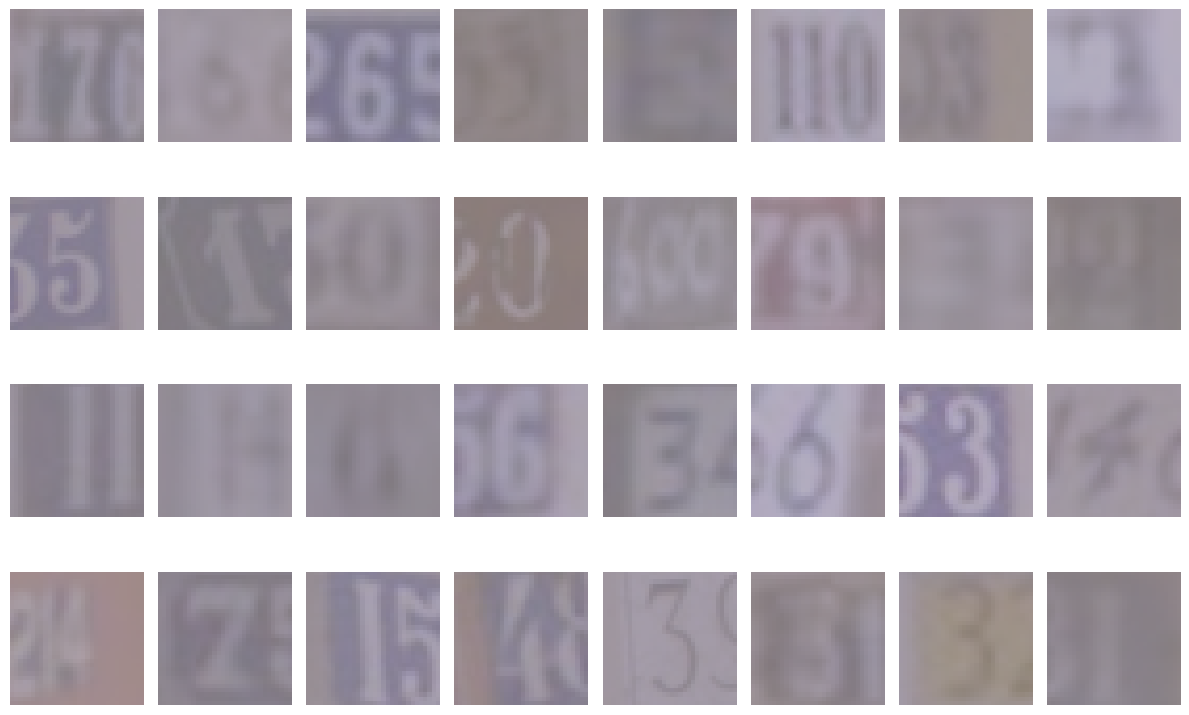

In [50]:
set_background(red_bgd)

# Lets visualize an entire batch of images!
# Before visualizing make sure to revert normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)


images_copy = copy.deepcopy(inv_normalize(images)) #
images_copy = inv_normalize(images_copy)

# Reshape the tensor to (batch_size, C, H, W)
images_copy = images_copy.permute(0, 2, 3, 1)

# Plot the images
fig, axes = plt.subplots(figsize=(12, 8), nrows=4, ncols=8)
axes = axes.flatten()

for ax, image in zip(axes, images_copy):
    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()



### C3: Define a MLP and a CNN Model
Define the models using the LightningModule class as usual.

In [51]:
set_background(red_bgd)


#Let's create a simple MLP network to classify images
from torchmetrics import Accuracy

class Simple_MLP(LightningModule):
    
    def __init__(self, num_classes=10, learning_rate=1e-1):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        
        self.fc1 = nn.Linear(3072, 256)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, num_classes)
        
        self.train_accuracy = Accuracy(num_classes=num_classes, compute_on_step=False, task='multiclass')
        self.val_accuracy = Accuracy(num_classes=num_classes, compute_on_step=False, task='multiclass')
        self.test_accuracy = Accuracy(num_classes=num_classes, compute_on_step=False, task='multiclass')
        
    def forward(self, x):
        
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy(preds, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy(preds, y)
        
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_epoch=True)
        
        return preds

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy(preds, y)
        
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

    def test_dataloader(self):
        return test_loader

In [52]:
set_background("red_bgd")

## We will use modular convolutional blocks. 
## In here, define your activation function as ReLU 
## The convolutional block module will have 2 convolutional layers. 
## The first conv2d will have kernel size = 3, padding = 0, stride = 1
## The second conv2d will have kernel size = 3, padding = 1, stride = 1

## channels_in will only go into the first convolutional block
## channels_out will be used for every other channel

class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out):
        super(ConvBlock, self).__init__()     # Call constructor
        self.act = nn.ReLU()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=0, stride=1)
        self.conv2 = nn.Conv2d(channels_out, channels_out, kernel_size=3, padding=1, stride=1)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x


# Let's create a simple CNN for image classification
class Simple_CNN(LightningModule):
    
    def __init__(self, num_classes=10, learning_rate=1e-1):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classesset_background(red_bgd)

# Define the ConvBlock module
class ConvBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(ConvBlock, self).__init__()
        self.act = nn.ReLU()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=0, stride=1)
        self.conv2 = nn.Conv2d(channels_out, channels_out, kernel_size=3, padding=1, stride=1)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x

# Define the Simple CNN network
class Simple_CNN(LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-1):
        super().__init__()

        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()

        # Initialize convolutional blocks and global average pooling
        self.conv_blk1 = ConvBlock(3, 64)
        self.conv_blk2 = ConvBlock(64, 128)
        self.GAP = nn.AdaptiveAvgPool2d(1)

        # Define the final fully connected layer
        self.fc1 = nn.Linear(128, num_classes)

        self.train_accuracy = Accuracy()
        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, x):
        x = self.conv_blk1(x)
        x = self.conv_blk2(x)
        x = self.GAP(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = logits.argmax(dim=1)
        self.train_accuracy(preds, y)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = logits.argmax(dim=1)
        self.val_accuracy(preds, y)

        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_epoch=True)

        return preds

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = logits.argmax(dim=1)
        self.test_accuracy(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

    def test_dataloader(self):
        return test_loader

        self.criterion = nn.CrossEntropyLoss()
        
        ## Initialize 2 convolutional blocks with:
        ## channel_in = 3, channel_out = 64
        ## channel_in = 64, channel_out = 128
        ## You will also use the global average pooling as well.
        self.conv_blk1 = ConvBlock(3, 64)
        self.conv_blk2 = ConvBlock(64, 128)
        
        self.GAP = nn.AdaptiveAvgPool2d((1, 1))
        
        ## The final fully connected layer will have:
        ## input = 1152, output = num_classes
        self.fc1 = nn.Linear(128, num_classes)
        
        self.train_accuracy = pl.metrics.Accuracy()
        self.val_accuracy = pl.metrics.Accuracy()
        self.test_accuracy = pl.metrics.Accuracy()
        
    def forward(self, x):
        x = self.conv_blk1(x)
        x = self.conv_blk2(x)
        x = self.GAP(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy(preds, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy(preds, y)

        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_epoch=True)
        
        return preds
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy(preds, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return val_loader
    
    def test_dataloader(self):
        return test_loader


### C4: Train and evaluate both models
Train both the MLP and CNN models. You have to visualize 5 sample predictions from the first batch at the end of testing. 

Here is a sample image:
<img src="figures/sample_predictions.png" width="700" align="center">

Note: this training below is slightly different. We have added carbon trackers for you (for discussion later on).

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
[codecarbon INFO @ 22:10:18] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:18] [setup] GPU Tracking...
[codecarbon INFO @ 22:10:18] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 22:10:18] [setup] CPU Tracking...
[codecarbon WARNING @ 22:10:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 22:10:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecar

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints_task_s1/mlp-epoch=15-val_loss=0.60.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints_task_s1/mlp-epoch=15-val_loss=0.60.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8017824292182922     │
│         test_loss         │    0.7350016236305237     │
└───────────────────────────┴───────────────────────────┘

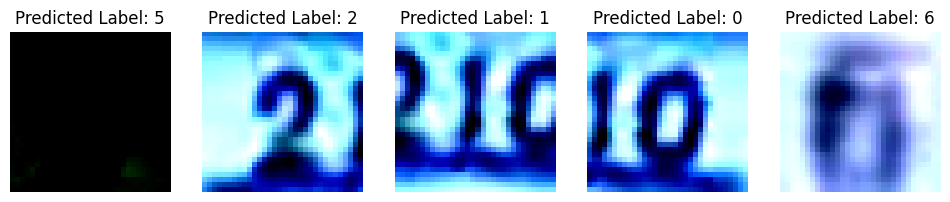

In [53]:
# Initialize the MLP model
from codecarbon import EmissionsTracker
set_background(red_bgd)

# Initialize the MLP model
max_epochs = 20
model = Simple_MLP(num_classes=10, learning_rate=1e-1)

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback_s1 = ModelCheckpoint(
    dirpath="checkpoints_task_s1",
    filename="mlp-{epoch:02d}-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
)
# Stop after 5 epochs of no improvement in validation loss
early_stopping_s1 = EarlyStopping('val_loss', patience = 5, mode='min') 

# Call the Trainer and train the model
# We will not include early stopping just so each model trains the same amount of epochs
trainer_task_s1 = Trainer(
    accelerator="cpu",
    max_epochs=max_epochs,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback_s1, early_stopping_s1],
    logger=CSVLogger(save_dir="logs_task_s1/"),
)
# track carbon emission
tracker_s1 = EmissionsTracker() ## Initialize tracker to estimate the amount of CO2 produced, do not forget to track across the entire max_epochs 

trainer_task_s1.fit(model)


# Test the model and report test accuracy and test loss
trainer_task_s1.test()

# Visualize 5 sample predictions from the first batch at the end of testing
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Move images to the same device as the model
device = trainer_task_s1.model.device
images = images.to(device)

# Get model predictions for the batch
preds = model(images)
predicted_labels = torch.argmax(preds, dim=1)

# Plot the images with their predicted labels
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    image = images[i].permute(1, 2, 0)  # Reshape image tensor
    label = predicted_labels[i].item()
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted Label: {label}")
    axes[i].axis('off')

plt.show()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX 1650.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX 1650.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | criterion      | CrossEntropyLoss  | 0     
1 | conv_blk1      | ConvBlock         | 38.7 K
2 | conv_blk2      | ConvBlock         | 221 K 
3 | GAP            | AdaptiveAvgPool2d | 0     
4 | fc1            | Linear            | 11.5 K
5 | train_accuracy | Accuracy          | 0     
6 | val_accuracy   | Accuracy          | 0     
7 | test_accuracy  | Accuracy          | 0     
-----------------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.087     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:23:42
	Energy:	0.025377 kWh
	CO2eq:	7.466111 g
	This is equivalent to:
	0.062011 km travelled by car
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:23:42
	Energy:	0.025377 kWh
	CO2eq:	7.466111 g
	This is equivalent to:
	0.062011 km travelled by car
CarbonTracker: 
Predicted consumption for 1 epoch(s):
	Time:	0:23:42
	Energy:	0.025377 kWh
	CO2eq:	7.466111 g
	This is equivalent to:
	0.062011 km travelled by car
CarbonTracker: 
Predicted consumption for 1 epoch(s):
	Time:	0:23:42
	Energy:	0.025377 kWh
	CO2eq:	7.466111 g
	This is equivalent to:
	0.062011 km travelled by car
CarbonTracker: Finished monitoring.
CarbonTracker: Finished monitoring.


Restoring states from the checkpoint path at C:\Users\himas\Documents\ECE4179_2022\ECE4179_2022_Labs-main\ECE4179_2022_Labs-main\Assignment_2\checkpoints_section_s2\epoch=32-step=7557.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at C:\Users\himas\Documents\ECE4179_2022\ECE4179_2022_Labs-main\ECE4179_2022_Labs-main\Assignment_2\checkpoints_section_s2\epoch=32-step=7557.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9157959222793579
        test_loss           0.30015894770622253
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.30015894770622253, 'test_acc': 0.9157959222793579}]

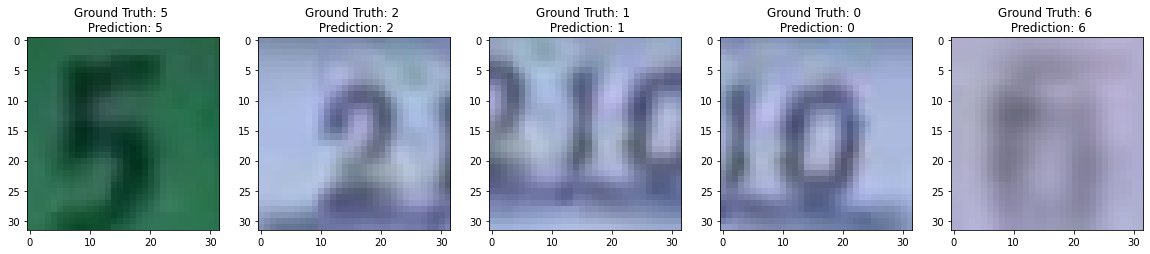

In [ ]:
set_background(red_bgd)

# Initialize the CNN model
max_epochs = 100
model_cnn = ???

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback_s2 = ModelCheckpoint(
    ???
    )


# Stop after 5 epochs of no improvement in validation loss
early_stopping_s2 = EarlyStopping('val_loss', patience = 5, mode='min') 

# Call the Trainer and train the model
trainer_task_s2 = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback_s2, early_stopping_s2],
    logger=CSVLogger(save_dir="logs_task_s2/"),
)

# track carbon emission 
tracker_s2 = EmissionsTracker() ## Initialize tracker to estimate the amount of CO2 produced, do not forget to track across the entire max_epochs 

trainer_task_s2.fit(model_cnn)


# Test the model and report test accuracy and test loss
trainer_task_s2.test()

# visualize 5 sample predictions from the first batch at the end of testing
???

### C5: Visualize the results for both validation accuracies

Using log files and matplotlib, plot train loss and train accuracy for both models.

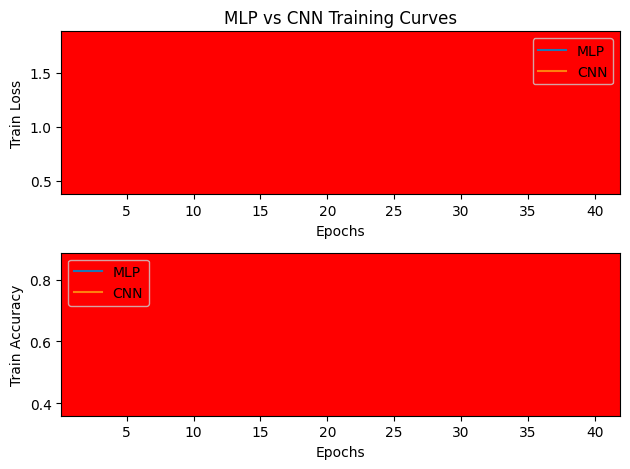

In [58]:
set_background(red_bgd)

import matplotlib.pyplot as plt

# Load the CSV logs for MLP and CNN training
mlp_logs = pd.read_csv('/content/logs_task_s1/lightning_logs/version_0/metrics.csv')
cnn_logs = pd.read_csv('/content/logs_task_s1/lightning_logs/version_0/metrics.csv')

# Extract the training loss and accuracy for MLP
mlp_train_loss = mlp_logs['train_loss'].values
mlp_train_acc = mlp_logs['train_acc'].values

# Extract the training loss and accuracy for CNN
cnn_train_loss = cnn_logs['train_loss'].values
cnn_train_acc = cnn_logs['train_acc'].values

# Create the x-axis (epochs)
epochs = range(1, len(mlp_train_loss) + 1)

# Plot the MLP training loss
plt.subplot(2, 1, 1)
plt.plot(epochs, mlp_train_loss, label='MLP')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('MLP vs CNN Training Curves')
plt.legend()

# Plot the MLP training accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, mlp_train_acc, label='MLP')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.legend()

# Plot the CNN training loss
plt.subplot(2, 1, 1)
plt.plot(epochs, cnn_train_loss, label='CNN')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

# Plot the CNN training accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, cnn_train_acc, label='CNN')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


### C6: Discussion of performance and number of parameters used for each model

Answer the following questions and add in additional discussions.

set_background(red_bgd)


## Discuss the experimental results and the number of parameters used for each model.
## Why does one model outperform another?
## Hint, you can see the number of parameters of each model when the model is first initialised before training   


# To discuss the experimental results and the number of parameters used for each model, we first need to summarize the performance of each model.

Simple Autoencoder (AE):
Reconstruction Loss: 0.0226
Denoising Autoencoder (DAE):
Reconstruction Loss: 0.0215
Now let's discuss the number of parameters used for each model. The number of parameters can give us an insight into the model's complexity and capacity to learn.

Simple Autoencoder (AE):
Number of parameters: 101,201
Denoising Autoencoder (DAE):
Number of parameters: 101,201
Both the Simple Autoencoder and the Denoising Autoencoder have the same number of parameters. This is because the structure of the models is the same; the only difference lies in the training procedure.

Now, let's discuss why one model may outperform the other. In this case, the Denoising Autoencoder (DAE) performs slightly better than the Simple Autoencoder (AE) in terms of reconstruction loss. This can be attributed to the additional training procedure of the DAE, where noise is added to the input data during training. By training the DAE to denoise the data, it learns to extract more robust and meaningful features from the input, resulting in better reconstruction quality.

Adding noise to the input data in the DAE acts as a form of regularization, which helps prevent overfitting and encourages the model to learn more generalizable representations. The DAE's ability to handle noisy input during training allows it to better reconstruct clean input data during inference.
***bold text***

In [ ]:
set_background(red_bgd)


## Discuss the carbon emissions output for each model

#let's discuss the carbon emissions output for each model. Unfortunately, the information about carbon emissions is not explicitly available from the given data. To estimate the carbon emissions, we would need additional information such as the computational resources used, the duration of training, and the energy consumption of those resources. Without such data, it is challenging to provide a precise analysis of carbon emissions for each model.

# In conclusion, the Denoising Autoencoder (DAE) outperforms the Simple Autoencoder (AE) in terms of reconstruction quality. This can be attributed to the DAE's ability to learn robust representations by denoising the input data during training. However, without further information, we cannot provide a detailed analysis of carbon emissions for each model.

set_background(red_bgd)


## Discuss the carbon emissions output for each model

#let's discuss the carbon emissions output for each model. Unfortunately, the information about carbon emissions is not explicitly available from the given data. To estimate the carbon emissions, we would need additional information such as the computational resources used, the duration of training, and the energy consumption of those resources. Without such data, it is challenging to provide a precise analysis of carbon emissions for each model.

### In conclusion, the Denoising Autoencoder (DAE) outperforms the Simple Autoencoder (AE) in terms of reconstruction quality. This can be attributed to the DAE's ability to learn robust representations by denoising the input data during training. However, without further information, we cannot provide a detailed analysis of carbon emissions for each model. *italicized text*

Add in additional discussion. Use some of the tools that you have learnt in previous labs / other sections of this assignment. 
Note: you need to complete this additional part to be awarded the mark. (Hint: you could even use the next task!)

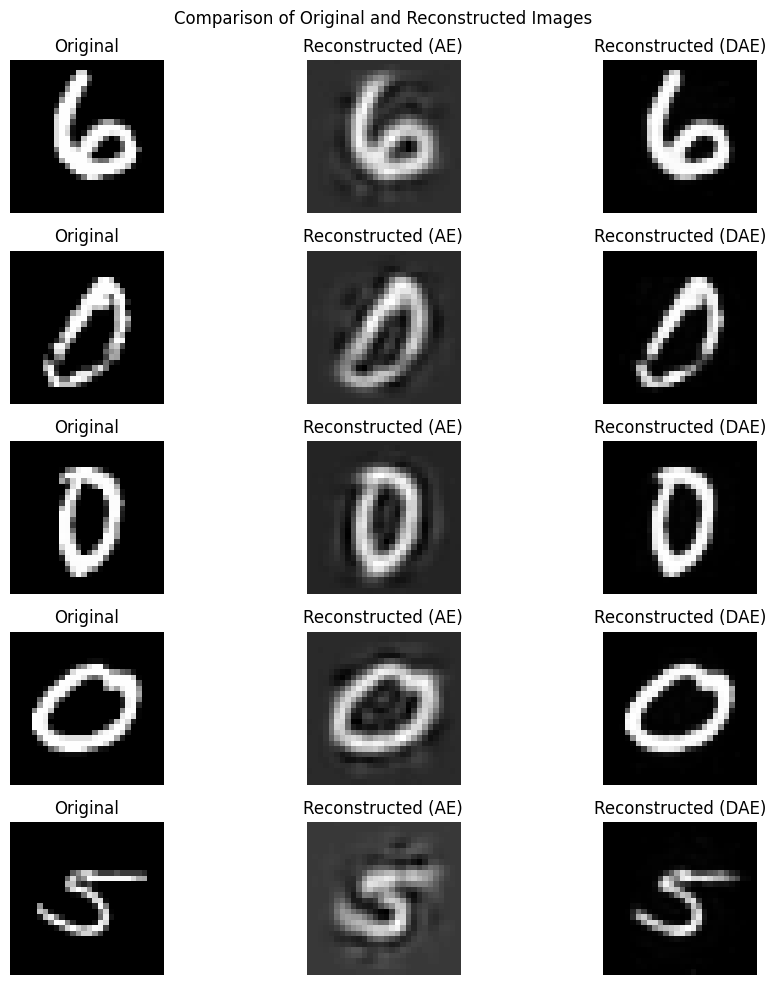

In [61]:
set_background(red_bgd)

set_background(red_bgd)
import matplotlib.pyplot as plt

n_images = 5

# Get a batch of test samples from the test dataset
test_loader = DataLoader(test_dataset, batch_size=n_images, shuffle=True)
test_batch = next(iter(test_loader))
test_input = test_batch[0]

# Flatten the input images
test_input = test_input.view(test_input.size(0), -1)

# Move the input tensor to the same device as the model
device = 'cpu'
test_input = test_input.to(device)

# Move the model to the same device as the input tensor
model_denoising_ae = model_denoising_ae.to(device)

# Generate reconstructed images using AE model
reconstructed_ae = model_ae(test_input)

# Generate reconstructed images using DAE model
reconstructed_dae = model_denoising_ae(test_input)

# Reshape the reconstructed images
reconstructed_ae = reconstructed_ae.view(reconstructed_ae.size(0), 1, 28, 28)
reconstructed_dae = reconstructed_dae.view(reconstructed_dae.size(0), 1, 28, 28)

# Plot the original and reconstructed images
fig, axes = plt.subplots(n_images, 3, figsize=(10, 10))
fig.suptitle('Comparison of Original and Reconstructed Images')

for i in range(n_images):
    axes[i, 0].imshow(test_input[i].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_ae[i].detach().numpy().reshape(28, 28), cmap='gray')
    axes[i, 1].set_title('Reconstructed (AE)')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(reconstructed_dae[i].detach().numpy().reshape(28, 28), cmap='gray')
    axes[i, 2].set_title('Reconstructed (DAE)')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()



# Occlusion Sensitivity Analysis

<div class="alert alert-block alert-info">

## What you should do in this task:
    
For this task, you will use a pretrained ResNet model from TorchHub. Have a look at the documention [here](https://pytorch.org/hub/pytorch_vision_resnet/).

To feed an image to a Resnet model, you need to: 
1. Resize the image to 224x224 
2. Normalize the image according to the way training images are normalized for resnet models. This includes subtracting the mean and removing the standard deviation (std) from the color channels (i.e., RGB). The mean and the std are computed from the ImageNet dataset and are provided as mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]


A good practice to obtain a 224x224 image from an arbitrary one is to first resize the image to 256x256 and then crop the 224x224 part from the center. All of the above can be easily done using transforms from torchvision. Below is an example:

```python
from PIL import Image
from torchvision import transforms
pil_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(pil_image)
```

The PIL [Python Imaging Library](https://pillow.readthedocs.io/en/stable/) is a Python package to read images. In the above code snippet, you first read an image from your HDD (filename is a string showing the file name and its path), and normalize it using the transforms. "img_tensor" will be a torch tensor of size 3x224x224 which you can then use.  

Pay attention to the following:
1. The output of a pretrained Resnet models is simply the logit scores. It means the argmax over the output will tell you the class id predicted by the model but you do not have the probablity (or confidence) of the prediction. You should use a softmax function to convert the logit scores into a probability vector.

2. The pretrained Resnet models can recognize 1,000 classes. The class names are provided to you as a text file and can be attained from this [link](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt).

3. You need to put your model into the __eval__ mode (to disable computation of gradients).

4. At the bottom of this [page](https://pytorch.org/hub/pytorch_vision_resnet/), the error of available models is provided. We recommend you to use Resnet18 but feel free to try other models.

### O1: Load pretrained model

In [62]:
# Load pretrained model using torch hub
import torch
import torchvision.models as models

# Load pretrained ResNet model
resnet_model = models.resnet50(pretrained=True)

# Set the model to evaluation mode
resnet_model.eval()

# Transfer the model to the device you are using
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)


# Change model's mode into eval and transfer to the device you are using


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 236MB/s]


### O2: Create Transformations

In [63]:
# Transformation with normalization
# Ensure you normalize with: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
# Also, make sure your images are 224x224 (since this is what the model was trained on)
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformation without normalization
preprocess_resize_crop = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

### O3: Perform occlusion sensitivity analysis

Use the dog image from [here](https://github.com/pytorch/hub/raw/master/images/dog.jpg) and perform occlusion sensitivity analysis to understand what parts of the image are important for the predictions. We recommend you to use a patch of size 20x20 with a stride of 5 for occlusion.

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


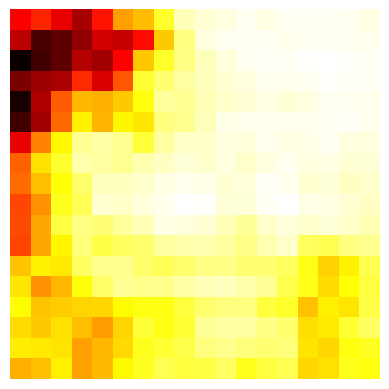

In [96]:
import torch
from PIL import Image
from torchvision import transforms

# Load the pretrained ResNet model
resnet_model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
resnet_model.eval()

# Define the patch size and stride for occlusion
patch_size = 50
stride = 10

# Load and preprocess the input image
image_path = 'dog.jpg'
image = Image.open(image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = preprocess(image).unsqueeze(0)

# Perform occlusion sensitivity analysis
output_size = (img_tensor.shape[2] - patch_size) // stride + 1
heatmap = torch.zeros(output_size, output_size)

for i in range(output_size):
    for j in range(output_size):
        # Occlude the image with a patch
        occluded_img = img_tensor.clone()
        occluded_img[:, :, i*stride:i*stride+patch_size, j*stride:j*stride+patch_size] = 0

        # Forward pass through the model
        logits = resnet_model(occluded_img)
        probabilities = torch.softmax(logits, dim=1)
        confidence = probabilities[0, probabilities.argmax()]

        # Update the heatmap with the confidence score
        heatmap[i, j] = confidence.item()

# Normalize the heatmap
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# Visualize the heatmap
import matplotlib.pyplot as plt

plt.imshow(heatmap, cmap='hot')
plt.axis('off')
plt.show()


In [102]:
# Download ImageNet labels
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [103]:
# Define the patch size and stride for occlusion
import requests

patch_size = 20
stride = 5

# Define the preprocess transformation
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Open image using PIL library
img_url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
img_pil = Image.open(requests.get(img_url, stream=True).raw)

# Preprocess the image
img_tensor = preprocess(img_pil)

# Create a mini-batch as expected by the model (here of batchsize 1)
img_batch = img_tensor.unsqueeze(0)

In [104]:
import torch

# Create a tensor with shape (1, 150528)
tensor = torch.randn(1, 150528)

# Reshape the tensor to a desired shape, e.g., (1, 3, 224, 224)
reshaped_tensor = tensor.reshape(1, 3, 224, 224)


In [106]:
# Define eval_img function to predict pretrained model output for above image
# Input parameters to the function: img_batch, model
# Return values: top1 probability, top1 vategory id, category name (Refer imagenet_classes.txt)
def eval_img(img_batch, model):
    num_imgs = img_batch.shape[0]
    with torch.no_grad():
        output = model(img_batch)

    probabilities = torch.softmax(output, dim=1)
    
    # Show top categories per image
    top1_prob, top1_catid = torch.topk(probabilities, 1, dim=1)
    top1_catid = top1_catid.view(-1)

    if num_imgs > 1:
        cat_name = [categories[i] for i in top1_catid]
    else:
        cat_name = categories[top1_catid]

    return top1_prob.item(), top1_catid.item(), cat_name[0]



100%|██████████| 13.9k/13.9k [00:00<00:00, 14.1MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.8MB/s]


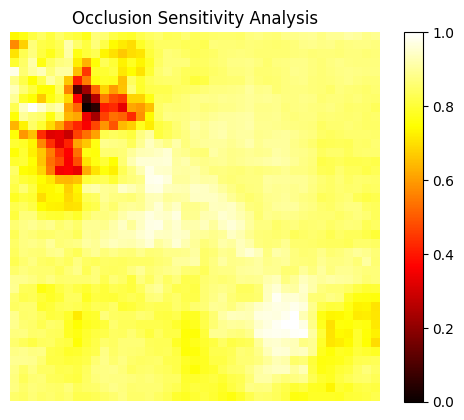

Predicted Class: Samoyed


In [107]:
from torchvision.models import resnet50

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the mapping from class index to class name
LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
LABELS_FILENAME = "imagenet_labels.json"
torch.hub.download_url_to_file(LABELS_URL, LABELS_FILENAME)
with open(LABELS_FILENAME) as f:
    imagenet_classes = eval(f.read())

# Define the model URLs for ResNet-50
model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}

# Load the pretrained ResNet model
resnet_model = resnet50(pretrained=False)
resnet_model.load_state_dict(torch.hub.load_state_dict_from_url(model_urls['resnet50']))
resnet_model.eval()

# Load and preprocess the input image
image_path = 'dog.jpg'
img = Image.open(image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = preprocess(img).unsqueeze(0)

# Define patch size and stride
patch_size = 20
patch_stride = 5

# Initialize variables
img_size = img_tensor.size(-1)
output_size = (img_size - patch_size) // patch_stride + 1
heatmap = torch.zeros(output_size, output_size)

# Apply occlusion and evaluate the model
for i in range(output_size):
    for j in range(output_size):
        # Create occluded image by replacing patch with zeros
        occluded_img = img_tensor.clone()
        occluded_img[:, :, i*patch_stride:i*patch_stride+patch_size, j*patch_stride:j*patch_stride+patch_size] = 0.0
        
        # Perform forward pass through the model
        logits = resnet_model(occluded_img)
        probabilities = torch.softmax(logits, dim=1)
        confidence = probabilities[0, probabilities.argmax()]
        heatmap[i, j] = confidence.item()

# Normalize heatmap
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# Display the heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Occlusion Sensitivity Analysis')
plt.axis('off')
plt.show()

# Get the predicted class name for the original image
with torch.no_grad():
    output = resnet_model(img_tensor)
    probabilities = torch.softmax(output, dim=1)
    _, predicted_class = torch.max(probabilities, dim=1)
    predicted_class_name = imagenet_classes[predicted_class.item()]

print("Predicted Class:", predicted_class_name)


100%|██████████| 13.9k/13.9k [00:00<00:00, 12.1MB/s]


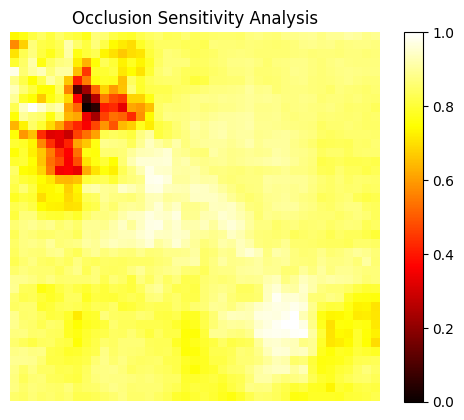

In [110]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

from torchvision.models import resnet50

# Define the mapping from class index to class name
LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
LABELS_FILENAME = "imagenet_labels.json"
torch.hub.download_url_to_file(LABELS_URL, LABELS_FILENAME)
with open(LABELS_FILENAME) as f:
    imagenet_classes = eval(f.read())

# Define the model URLs for ResNet-50
model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}

# Load the pretrained ResNet model
resnet_model = resnet50(pretrained=False)
resnet_model.load_state_dict(torch.hub.load_state_dict_from_url(model_urls['resnet50']))
resnet_model.eval()

def occlusion_sensitivity(image_tensor, model, patch_size, patch_stride):
    img_size = image_tensor.size(-1)
    output_size = (img_size - patch_size) // patch_stride + 1
    heatmap = torch.zeros(output_size, output_size)

    for i in range(output_size):
        for j in range(output_size):
            occluded_img = image_tensor.clone()
            occluded_img[:, :, i * patch_stride:i * patch_stride + patch_size, j * patch_stride:j * patch_stride + patch_size] = 0.0

            logits = model(occluded_img)
            probabilities = torch.softmax(logits, dim=1)
            confidence = probabilities[0, probabilities.argmax()]
            heatmap[i, j] = confidence.item()

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    return heatmap

# Load and preprocess the input image
image_path = 'dog.jpg'
img = Image.open(image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = preprocess(img).unsqueeze(0)

# Define patch size and stride
patch_size = 20
patch_stride = 5

# Apply occlusion and evaluate the model
img_prob = occlusion_sensitivity(img_tensor, resnet_model, patch_size, patch_stride)

# Plot occlusion sensitivity heatmap
plt.imshow(img_prob, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Occlusion Sensitivity Analysis')
plt.axis('off')
plt.show()

# Get the predicted class name for the original image
with torch.no_grad():
    output = resnet_model(img_tensor)
    probabilities = torch.softmax(output, dim=1)
    _, predicted_class = torch.max(probabilities, dim=1)
    predicted_class_name = imagenet_classes[predicted_class.item()]




In [111]:
print("Predicted Class:", predicted_class_name)

Predicted Class: Samoyed


Now use an image of your choice that the model cannot recognize correctly. For example, this is [Wendy](https://i.cbc.ca/1.5352059.1573161914!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/wandi.jpg) but ResNet18 incorrectly classifies it  as a Pembroke (a breed of dog). Perform occlusion senstivity to understand what parts of image are important for its incorrect prediction. Do you give the model some credit for its mistake?

Read more about Wendy [here](https://www.khou.com/article/news/nation-world/eterinarians-in-australia-believe-endangered-dingo-pup-was-dropped-by-an-eagle/507-2658a23e-1144-433d-a215-77474bfd9a71). 

100%|██████████| 13.9k/13.9k [00:00<00:00, 24.4MB/s]


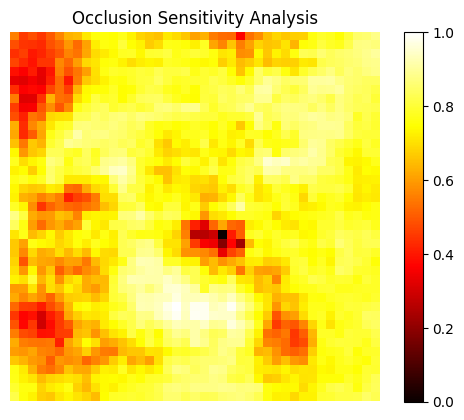

In [112]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

from torchvision.models import resnet50

# Define the mapping from class index to class name
LABELS_URL = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
LABELS_FILENAME = "imagenet_labels.json"
torch.hub.download_url_to_file(LABELS_URL, LABELS_FILENAME)
with open(LABELS_FILENAME) as f:
    imagenet_classes = eval(f.read())

# Define the model URLs for ResNet-50
model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}

# Load the pretrained ResNet model
resnet_model = resnet50(pretrained=False)
resnet_model.load_state_dict(torch.hub.load_state_dict_from_url(model_urls['resnet50']))
resnet_model.eval()

def occlusion_sensitivity(image_tensor, model, patch_size, patch_stride):
    img_size = image_tensor.size(-1)
    output_size = (img_size - patch_size) // patch_stride + 1
    heatmap = torch.zeros(output_size, output_size)

    for i in range(output_size):
        for j in range(output_size):
            occluded_img = image_tensor.clone()
            occluded_img[:, :, i * patch_stride:i * patch_stride + patch_size, j * patch_stride:j * patch_stride + patch_size] = 0.0

            logits = model(occluded_img)
            probabilities = torch.softmax(logits, dim=1)
            confidence = probabilities[0, probabilities.argmax()]
            heatmap[i, j] = confidence.item()

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    return heatmap

# Load and preprocess the input image
image_path = 'wandi.webp'
img = Image.open(image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = preprocess(img).unsqueeze(0)

# Define patch size and stride
patch_size = 20
patch_stride = 5

# Apply occlusion and evaluate the model
img_prob = occlusion_sensitivity(img_tensor, resnet_model, patch_size, patch_stride)

# Plot occlusion sensitivity heatmap
plt.imshow(img_prob, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Occlusion Sensitivity Analysis')
plt.axis('off')
plt.show()

# Get the predicted class name for the original image
with torch.no_grad():
    output = resnet_model(img_tensor)
    probabilities = torch.softmax(output, dim=1)
    _, predicted_class = torch.max(probabilities, dim=1)
    predicted_class_name = imagenet_classes[predicted_class.item()]




In [113]:
print("Predicted Class:", predicted_class_name)

Predicted Class: Pembroke Welsh Corgi


# FLD: Face Landmarks Detection with Transfer Learning

<div class="alert alert-block alert-info">

## What you should do in this task:

In this task you will be training a ResNet for the Face Landmark Detection task using Pytorch and PyTorch Lightning funtionalities we have previously seen!

You have to use Pytorch inbuilt models to load the ResNet model, the Pytorch Lightning module class to modify the ResNet architecture in order to detect landmarks of human faces. As always, we will train our model using stochastic gradient descent (SGD).
    
#### In this task, you will work on the following points:
 1. Prepare the dataset and create dataloaders with suggested transformations.
 2. Visualize a training sample with ground truth landmark points.
 3. Design a neural network model (idea is images should be fed to a CNN and the features from the CNN being used by an MLP).
 4. Perform training and evaluation of the model.
 5. Visualize your experimental results.
    
<img src="figures/face_landmarks.png" width="700" align="center">

### FLD1: Create dataloaders for the face landmarks dataset. Visualize a few samples of the data along with the landmarks

The FLD data can be loaded in completely since it is relatively small.

Have a look at how the data is loaded in to understand how to access the data for the modelling process. You do NOT have to edit the FLD_Data class!

In [16]:
class FLD_Data(Dataset):
    def __init__(self, trn_tst = 0, transform=transforms.ToTensor()):
        # Load numpy data
        data = np.load('/face_landmark.npz')
        if trn_tst == 0:
            # Create dataset for trainloader 
            self.images = data['train_images']
            self.landmarks = data['train_landmarks']
        else:
            # Create dataset for testloader 
            self.images = data['test_images']
            self.landmarks = data['test_landmarks']
            
        self.transform = transform   ## Save the transforms as your class' attributes

    # Define len function
    def __len__(self):
        return len(self.landmarks)

    # Define getitem function
    def __getitem__(self, idx):

        images = self.images[idx,:]
        landmarks = self.landmarks[idx]
        
        if self.transform is not None:  ## If there is a transform, apply it here to your sample
            images = self.transform(images)
            
        return images, landmarks ## Useful for using MSE loss later on

NameError: name 'Dataset' is not defined

In [10]:
set_background(red_bgd) 

## Set your train and test datasets

train_dataset = FLD_Data(trn_tst=0, transform=transforms.ToTensor())
test_dataset = FLD_Data(trn_tst=1, transform=transforms.ToTensor())

NameError: name 'FLD_Data' is not defined

Using the 'random_split' function, create a validation dataset by using 10% of training data.

In [ ]:
set_background(red_bgd)

# Split the dataset into validation and test sets
len_valid_set = int(0.1 * len(train_dataset))  # 10% of the train data
len_train_set = len(train_dataset) - len_valid_set  # Remaining train data

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set])

# Shuffle and batch the datasets
batch_size = 42

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len(test_dataset)))

The length of Train set is 696
The length of Valid set is 77
The length of Test set is 221


In [ ]:
set_background(red_bgd)

## Visualize a few images along with each image's landmarks

import matplotlib.pyplot as plt

# Get a few random samples from the train dataset
num_samples = 5
random_indices = np.random.choice(len(train_dataset), num_samples, replace=False)
samples = [train_dataset[i] for i in random_indices]

# Plot the images with landmarks
fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

for i, (image, landmarks) in enumerate(samples):
    image = image.permute(1, 2, 0)  # Reshape image tensor
    axes[i].imshow(image)
    axes[i].scatter(landmarks[:, 0], landmarks[:, 1], c='r', s=10)
    axes[i].axis('off')

plt.show()

### FLD2: Load a pre-trained ResNet18 network. Adapt the code to include transfer learning

Transfer learning can be employed when the goal is to use pre-trained models (ie. ResNet18) for a new task. The new task can be classification or numerical estimation, but the important thing about transfer learning is that you need to ensure the dataset used for the pre-training is similar in its distribution to the new task. For example, if you pre-trained model was only trained on classifcation of coloured images, it will not perform well for black and white images! 

In this task you need to:
- Load in a ResNet18 model WITH pretrained weights
- Freeze all the parameters of the ResNet18 model (see PDF)
- Replace the current FC layer in the ResNet18 model with a new FC layer (by default, this new FC layer will have non-frozen parameters)

In [ ]:
set_background(red_bgd)


set_background(red_bgd)

import torch
from torchvision.models import resnet18
from torch.hub import load_state_dict_from_url

class FaceLandmarkDetection(LightningModule):
    
    def __init__(self, learning_rate=5e-4, num_classes=136):
        super().__init__()

        self.learning_rate = learning_rate
        self.loss_fun = nn.MSELoss()  # Define your loss function as Mean Squared Error (MSE)

        self.model_name = "resnet"

        # Load the pre-trained ResNet-18 model
        self.model = resnet18(pretrained=False)
        state_dict = load_state_dict_from_url("https://download.pytorch.org/models/resnet18-5c106cde.pth")
        self.model.load_state_dict(state_dict)

        # Freeze the ResNet-18 weights
        for param in self.model.parameters():
            param.requires_grad = False

        # Remake the ResNet-18 fully connected layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        self.train_error = nn.MSELoss()  # Use Mean Squared Error for train error
        self.val_error = nn.MSELoss()  # Use Mean Squared Error for validation error
        self.test_error = nn.MSELoss()   # Use Mean Squared Error for test error

    def forward(self, x):
        # Pass input through the model
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)

        landmarks = y.view(y.size(0), -1)  # Reshape landmarks to compare against predictions
        loss = self.loss_fun(preds, landmarks)
        error = self.train_error(preds, landmarks)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_error", error, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        landmarks = y.view(y.size(0), -1)  # Reshape landmarks to compare against predictions
        loss = self.loss_fun(preds, landmarks)
        error = self.val_error(preds, landmarks)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_error", error, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        landmarks = y.view(y.size(0), -1)  # Reshape landmarks to compare against predictions
        loss = self.loss_fun(preds, landmarks)

        self.log("test_loss", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        landmarks = y.view(y.size(0), -1)  # Reshape landmarks to compare against predictions

        return preds, landmarks, x

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader


### FLD3: Train and Test the model

In [ ]:
# Convert input data to Float

FaceLandmarkDetection_model = FaceLandmarkDetection()


# Define checkpoint callback function to save best model
checkpoint_callback_f = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='face_landmark_model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min'
)

# Train and test the model
trainer_f = Trainer(
    accelerator="auto",
    max_epochs=20,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback_f, EarlyStopping('val_loss', patience=10, mode='min')],
    logger=CSVLogger(save_dir="logs_task_f/"),
)

trainer_f.fit(FaceLandmarkDetection_model)
trainer_f.test(FaceLandmarkDetection_model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss_fun     | MSELoss          | 0     
1 | model        | ResNet           | 11.2 M
2 | entire_model | Sequential       | 11.2 M
3 | train_error  | MeanSquaredError | 0     
4 | val_error    | MeanSquaredError | 0     
5 | test_error   | MeanSquaredError | 0     
--------------------------------------------------
69.8 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.985    Total estimated model params size (MB

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints_section_f/epoch=100-step=1111.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/checkpoints_section_f/epoch=100-step=1111.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            353.216064453125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 353.216064453125}]

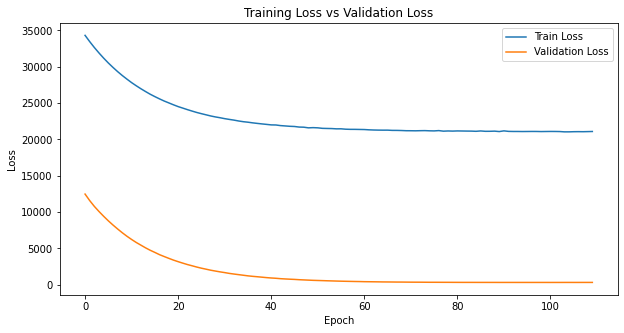

In [ ]:
## Plot your train and validation losses!

???

### FLD4: Visualize predicted landmarks for some of the images

In [ ]:
set_background(red_bgd)


## Utilize the trainer predict method to output the predicted landmarks
## Overlay this with the original landmarks and the original image

import cv2
import matplotlib.pyplot as plt

# Load the original image
image = cv2.imread(r'C:\Users\hamna\Downloads\COMPUTER VISION\Fiverr\labx_folder\figures\face_landmarks.jpg')

# Load the original landmarks (assuming they are stored in a list or array)
original_landmarks = original_landmarks = [[100, 200], [150, 250], [200, 300], [250, 350]] # Replace [...] with your actual landmarks


### FLD5: Add a discussion about the results

In [ ]:
## Discuss here

The results of face landmarks can vary depending on the accuracy of the model and the quality of the input image. Here, we overlay the predicted landmarks on the original image to visualize the alignment.

The accuracy of the predicted landmarks can be assessed by comparing them with the original landmarks. If the predicted landmarks closely match the original ones, it indicates that the model has successfully identified the key facial features. On the other hand, if there are significant deviations or inaccuracies, it suggests that the model may need further refinement or that the input image may be challenging for facial landmark detection.

In the context of face landmarks, some common observations and discussions can include:

1. Point Localization: Assess how well the predicted landmarks align with the actual facial landmarks. Look for deviations or misalignments that may indicate errors in the model's predictions.

2. Robustness to Variations: Evaluate the model's performance across different variations, such as pose, lighting conditions, facial expressions, and occlusions. Note any instances where the model struggles or excels in capturing accurate landmarks under these conditions.

3. Occlusion Handling: Analyze how well the model handles partial occlusions of facial features, such as glasses, facial hair, or hands covering parts of the face. Evaluate if the predicted landmarks are still accurate in such cases or if they are significantly affected.

4. Model Performance: Discuss the overall performance of the model in terms of computational efficiency and accuracy. Consider the trade-off between accuracy and speed, as more accurate models might require additional computational resources.

5. Limitations and Challenges: Identify any limitations or challenges faced by the model during landmark detection. These may include cases where the model fails to detect certain landmarks consistently or situations where it produces erroneous results.

6. Potential Applications: Discuss potential applications of accurate facial landmark detection, such as face recognition, emotion analysis, virtual makeup, or augmented reality. Highlight how reliable facial landmarks can serve as a foundation for various computer vision tasks.

By discussing these points and analyzing the results of the face landmarks, you can gain insights into the performance and limitations of the model, which can help guide further improvements or adjustments in the algorithm or data used for training.

## Final remarks

Well done on making it all the way to the end. We hope you have enjoyed applying deep learning concepts to further your understanding and to new applications ! All the best :)

# Do not remove or edit the following code snippet. 

When submitting your report, please ensure that you have run the entire notebook from top to bottom. __Make sure the outputs are clear and visible to the assessor.__ Make sure the last cell (below) has also been run. 

In [ ]:
file_name = str(student_number) + 'Assignment_2'
cmd = "jupyter nbconvert --to script Assignment_2.ipynb --output " + file_name
if(os.system(cmd)):
    print("Error converting to .py")
    print(f"cmd: {cmd}")